In [48]:
from drn_interactions.brain_state_transforms import BrainStateUtils
from drn_interactions.phaselocking import load_phaselock_data, align_spikes_to_phase, get_phase, circstats
from drn_interactions.plots import circular_hist
from drn_interactions.stats import p_adjust

from astropy import units as u
from scipy.stats import chi2_contingency
from astropy.stats import circmean

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from IPython.display import display
sns.set_theme(context="poster", style="ticks")

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Preprocess Data

In [49]:
# load data
transformer =  BrainStateUtils()
neurons, spikes, df_eeg, eeg_states = load_phaselock_data()

# align eeg phase to states
df_eeg = transformer.align_eegraw_state(df_eeg, eeg_states)
df_eeg = get_phase(df_eeg)

# align spikes to eeg phase  (separately for each state)
sw = df_eeg.query("state == 'sw'")[["session_name", "time", "raw", "delta", "delta_phase",]].copy()
act = df_eeg.query("state == 'act'")[["session_name", "time", "raw", "theta", "theta_phase",]].copy()
df_sw = align_spikes_to_phase(spikes, sw)
df_act = align_spikes_to_phase(spikes, act)

## Statistical Modeling

- For each brain state, the phase histogram of each neuron is tested for uniformity using Raleigh's test 

In [50]:
# compute phase locking for all neurons during SW
res_sw = (
    df_sw.groupby("neuron_id", as_index=False)
    .delta_phase
    .apply(lambda x: circstats(x.values * u.radian))
    .assign(p=lambda x: p_adjust(x.p)) 
    .round(3)
    .assign(sig_delta=lambda x: x.p < 0.05)
)

# compute phase locking for all neurons during ACT
res_act = (
    df_act.groupby("neuron_id", as_index=False)
    .theta_phase
    .apply(lambda x: circstats(x.values * u.radian))
    .assign(p=lambda x: p_adjust(x.p))
    .round(3)
    .assign(sig_theta=lambda x: x.p < 0.05)
)

df_res = pd.merge(
    res_act, res_sw, 
    on="neuron_id", 
    suffixes=("_act", "_sw")
    ).merge(
        neurons[["neuron_id", "session_name", "wf_3"]]
        )
df_res.head(3)

,neuron_id,mean_act,std_act,p_act,sig_theta,mean_sw,std_sw,p_sw,sig_delta,session_name,wf_3
0,81,-74.965,1.393,0.338,False,149.861,1.404,0.387,False,ESHOCK_07_LOC1,sir
1,82,-76.699,1.399,0.886,False,-173.554,1.403,0.880,False,ESHOCK_07_LOC1,sir
2,84,149.164,1.403,0.732,False,97.514,1.364,0.000,True,ESHOCK_07_LOC1,sr


In [52]:
# How many neurons were significantly phase locked during each state?
# Did this differ by neuron type?

def prop_stats(x: pd.Series) -> pd.Series:
    return pd.Series({"num": len(x), "pct": x.mean()})


display(prop_stats(df_res["sig_delta"]).to_frame(name="Delta").transpose())
display(df_res.groupby("wf_3", as_index=False)["sig_delta"].apply(prop_stats).round(3))
X = pd.crosstab(df_res["wf_3"], df_res["sig_delta"])
stat, p, dof, expected = chi2_contingency(X)
print(stat, p, dof)

print()
display(prop_stats(df_res["sig_theta"]).to_frame(name="Theta").transpose())
display(df_res.groupby("wf_3", as_index=False)["sig_theta"].apply(prop_stats).round(3))
X = pd.crosstab(df_res["wf_3"], df_res["sig_theta"])
stat, p, dof, expected = chi2_contingency(X)
print(stat, p, dof)

,num,pct
Delta,133.0,0.706767


,wf_3,num,pct
0,ff,28.0,0.893
1,sir,42.0,0.667
2,sr,63.0,0.651


5.956863369097412 0.050872555549098024 2



,num,pct
Theta,133.0,0.263158


,wf_3,num,pct
0,ff,28.0,0.393
1,sir,42.0,0.262
2,sr,63.0,0.206


3.477947845804989 0.17570059050876632 2


,num,pct
Delta,94.0,-59.326755


,wf_3,num,pct
0,ff,25.0,-29.733
1,sir,28.0,-61.921
2,sr,41.0,-75.600


,num,pct
Theta,35.0,13.506771


,wf_3,num,pct
0,ff,11.0,16.128
1,sir,11.0,40.361
2,sr,13.0,-11.434


c:\users\roryl\repos\drn interactions\drn_interactions\plots.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator


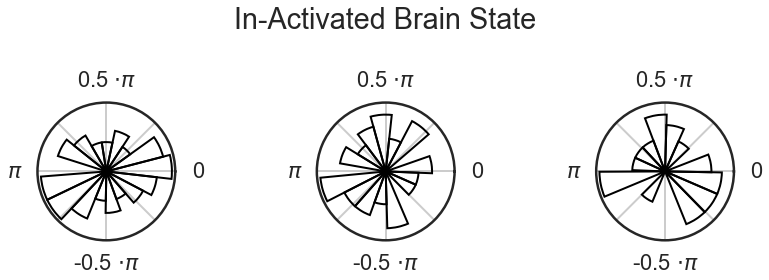

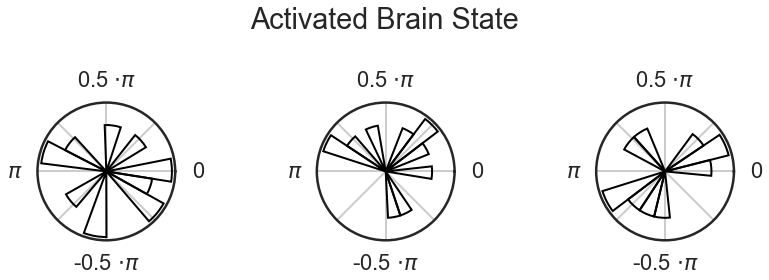

In [168]:
# among phase locked units, what is their prefered angle?

df1 = df_res.query("sig_delta == True")

def angle_stats(x: pd.Series) -> pd.Series:
    return pd.Series({"mean": circmean(x * u.deg).value, "std": x.std()})

display(prop_stats(df1["mean_sw"]).to_frame(name="Delta").transpose())
display(df1.groupby("wf_3", as_index=False)["mean_sw"].apply(prop_stats).round(3))

print()
df2 = df_res.query("sig_theta == True")

display(prop_stats(df2["mean_act"]).to_frame(name="Theta").transpose())
display(df2.groupby("wf_3", as_index=False)["mean_act"].apply(prop_stats).round(3))

f, axes = plt.subplots(1, 3, figsize=(12, 4), subplot_kw=dict(projection="polar"))
circular_hist(df1.query("wf_3 == 'sr'")["mean_sw"], density=True, linewidth=2, ax=axes[0])
circular_hist(df1.query("wf_3 == 'sir'")["mean_sw"], density=True, linewidth=2, ax=axes[1])
circular_hist(df1.query("wf_3 == 'ff'")["mean_sw"], density=True, linewidth=2, ax=axes[2])
f.suptitle("In-Activated Brain State")
f.tight_layout()


f, axes = plt.subplots(1, 3, figsize=(12, 4), subplot_kw=dict(projection="polar"))
circular_hist(df2.query("wf_3 == 'sr'")["mean_act"], density=True, linewidth=2, ax=axes[0])
circular_hist(df2.query("wf_3 == 'sir'")["mean_act"], density=True, linewidth=2, ax=axes[1])
_ = circular_hist(df2.query("wf_3 == 'ff'")["mean_act"], density=True, linewidth=2, ax=axes[2])
f.suptitle("Activated Brain State")
f.tight_layout()



## Plot Examples

- For each of SW and ACT
- Raw EEG, Filtered EEG, Instantaneous Phase, Concurrent Spiking
- Phase Histogram

In [60]:
candidate = df_res.query("sig_delta == True").sample(1)
# candidate.neuron_id

50    147
Name: neuron_id, dtype: int64

C:\Users\roryl\AppData\Local\Temp\ipykernel_4824\2840855301.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(["", "$-\pi$", "0", "$\pi$", ""])


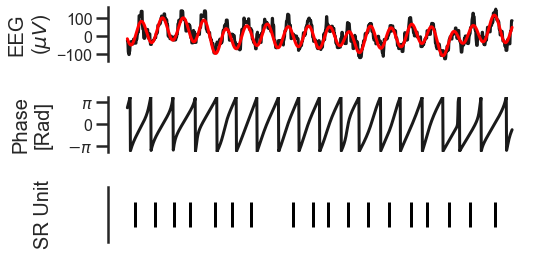

In [169]:
from neurodsp.plts import plot_time_series, plot_instantaneous_measure

# candidate_neuron = candidate.neuron_id.values[0]
candidate_neuron = 167
t_start = 165
duration = 5
dfp = df_eeg.query("state == 'sw' and session_name == @candidate.session_name.values[0]").dropna()
dfp = dfp.query("time > @t_start and time < @t_start + @duration")
spikes_plot = spikes.query("neuron_id == @candidate_neuron and spiketimes > @t_start and spiketimes < @t_start + @duration")["spiketimes"].values

f, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True)

plot_time_series(dfp.time.values, dfp.raw.values, ax=axes[0])
axes[0].get_xaxis().set_visible(False)
plot_time_series(dfp.time.values, dfp.delta.values, ax=axes[0], colors="red", label="filtered")
plot_instantaneous_measure(dfp.time.values, dfp.delta_phase.values, ax=axes[1], label="angle")
axes[1].get_xaxis().set_visible(False)
axes[1].set_ylim(-np.pi, np.pi)
axes[1].set_yticklabels(["", "$-\pi$", "0", "$\pi$", ""])
sns.despine()
axes[2].eventplot(spikes_plot, color="black")
axes[2].get_xaxis().set_visible(False)
axes[2].spines.left.set_visible(False)
axes[2].set_yticks([])

axes[0].set_ylabel("EEG\n($\mu V$)", fontsize="small")
axes[1].set_ylabel("Phase\n[Rad]", fontsize="small")
axes[2].set_ylabel("SR Unit", fontsize="small")
sns.despine(bottom=True)
f.tight_layout()
f.align_ylabels()

c:\users\roryl\repos\drn interactions\drn_interactions\plots.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(0, 100.0, ''), Text(0, 200.0, ''), Text(0, 300.0, '')]

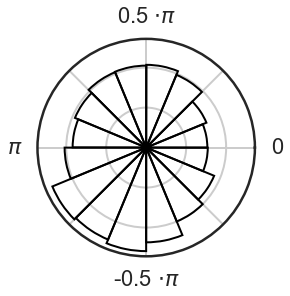

In [170]:
ax = circular_hist(df_sw.query("neuron_id == @candidate_neuron")["delta_phase"], bins=16, linewidth=2, density=False)

ax.set_yticklabels([])